# Vehicle Detection
*Brian Erickson*

This notebook implements the *Vehicle Detection* project of the Udacity Self Driving Car NanoDegree.

It includes both investigations and the solution to the project.  

The rubric for the project is located here:

Rubric for the project is located [here](https://review.udacity.com/#!/rubrics/513/view)

## Todo:

    [ ] Perform HOG once per image
    [ ] Figure out how long each step is taking
    [ ] Heat map for single frame
    [ ] Heat map across frames
    [ ] Bounding Box

## Imports and Helper Functions

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import os.path
import wget # conda install wget
import zipfile
import glob

import matplotlib.image as mpimg
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import collections
import random
from profiler import Profiler

import scipy.ndimage
%matplotlib inline


In [2]:
profiler = Profiler()

## Get Training Data

In [3]:
# vehicles
if not os.path.exists('datasets/vehicles'):
    f = wget.download('https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip')
    with zipfile.ZipFile(f, 'r') as z:
        z.extractall(path='datasets')
    os.remove(f)

    

In [4]:
# non-vehicles
if not os.path.exists('datasets/non-vehicles'):
    f = wget.download('https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip')
    with zipfile.ZipFile(f, 'r') as z:
        z.extractall(path='datasets')
    os.remove(f)


In [5]:
test_images = glob.glob('test_images/*')
test_images.sort()
test_images

['test_images/test1.jpg',
 'test_images/test2.jpg',
 'test_images/test3.jpg',
 'test_images/test4.jpg',
 'test_images/test5.jpg',
 'test_images/test6.jpg']

In [6]:
# Read in car and non-car images
cars = glob.glob('datasets/vehicles/**/*.png',recursive=True)
notcars = glob.glob('datasets/non-vehicles/**/*.png',recursive=True)
images= cars+notcars

print('cars:',len(cars),' noncars:',len(notcars), ' total:',len(cars)+len(notcars))



cars: 8792  noncars: 8968  total: 17760


## Investigations

### Color Spaces

In [7]:
colorspaces = ['RGB','HSV','LUV','HLS','YUV','YCrCb']

In [8]:
def rgb_to_colorspace(image, colorspace):
    if image.dtype == 'float32':
        im=(image * 255).astype(np.uint8)
    else:
        im = image
    #im=image.astype(np.float32)/np.max(image)
    rv = None
    if colorspace == 'RGB':
        rv = np.copy(im)
    elif colorspace == 'HSV':
        rv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
    elif colorspace == 'LUV':
        rv = cv2.cvtColor(im, cv2.COLOR_RGB2LUV)
    
    elif colorspace == 'HLS':
        rv = cv2.cvtColor(im, cv2.COLOR_RGB2HLS)
    elif colorspace == 'YUV':
        rv = cv2.cvtColor(im, cv2.COLOR_RGB2YUV)
    elif colorspace == 'YCrCb':
        rv = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)
    else:
        raise ValueError("unsupported colorspace "+str(colorspace))
        
    if np.min(rv)<0:
        raise ValueErrr ('negative color returned')
    return rv


channel 0 range 0 - 255, channel 1 range 0 - 255, channel 2 range 0 - 255, 
channel 0 range 29 - 175, channel 1 range 38 - 177, channel 2 range 34 - 175, 
channel 0 range 33 - 159, channel 1 range 39 - 169, channel 2 range 42 - 171, 


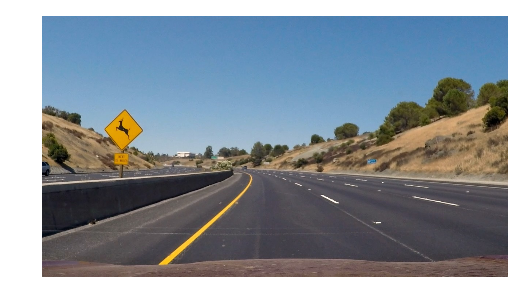

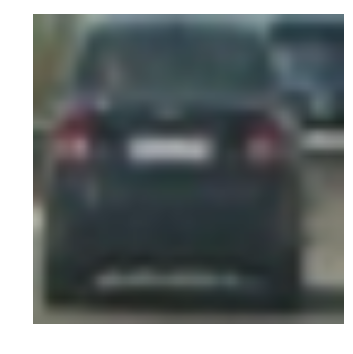

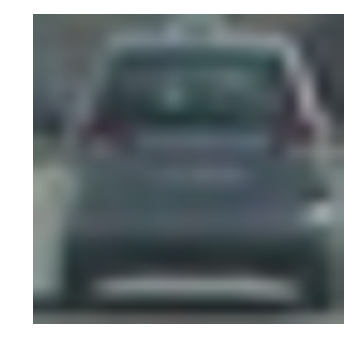

In [9]:
# ensure color ranges are OK
images = (plt.imread('test_images/test2.jpg'),scipy.ndimage.imread('datasets/vehicles/GTI_MiddleClose/image0000.png',mode='RGB'),plt.imread('datasets/vehicles/GTI_Far/image0003.png'))
for image in images:
        im=rgb_to_colorspace(image,'RGB')
        for channel in range(3):
            print('channel',channel,'range',np.min(im[:,:,channel]),'-',np.max(im[:,:,channel]),end=', ')
        plt.figure()
        plt.imshow(im)
        plt.axis('OFF')
            
        print()


### Color Classify
based on lesson 26

In [10]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split

# Define a function to compute binned color features  
def bin_spatial(img, size=32):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, (size,size)).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_color_features(im, spatial_size, hist_bins, hist_range):
    '''
    returns color features for single image
    
    im must already be in the correct color space
    '''
    spatial_features = bin_spatial(im, size=spatial_size)
    hist_features = color_hist(im, nbins=hist_bins, bins_range=hist_range)
    features = np.concatenate((spatial_features, hist_features))
    return features


In [11]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orientations, pixels_per_cell, cells_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                                  cells_per_block=(cells_per_block, cells_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                       cells_per_block=(cells_per_block, cells_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def hog_features_for_patch(im,hog_channel,orientations,pixels_per_cell,cells_per_block):
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(im.shape[2]):
                hog_features.append(get_hog_features(im[:,:,channel], 
                                    orientations, pixels_per_cell, cells_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(im[:,:,hog_channel], orientations, 
                        pixels_per_cell, cells_per_block, vis=False, feature_vec=True)    
        return hog_features



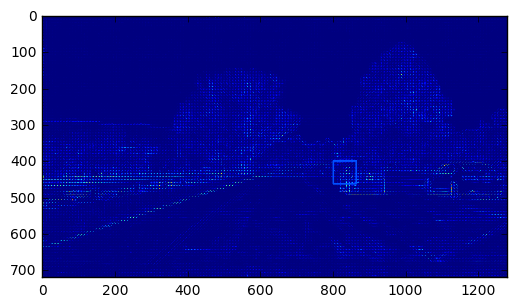

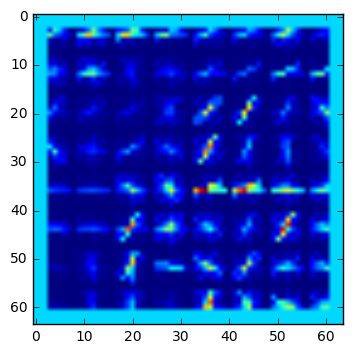

In [12]:
im=plt.imread(test_images[0])
features,hog_image = get_hog_features(im[:,:,0],orientations=16,pixels_per_cell=8,cells_per_block=1,vis=True)
plt.figure()
x1,x2,y1,y2=400,463,800,863
cv2.rectangle(hog_image,(800,400),(863,463),(1,1,1),thickness=4)
plt.imshow(hog_image)
plt.figure()
plt.imshow(hog_image[400:464,800:864])


#### Try HOG on Test Image

In [13]:
def smaller_size(im):
    return cv2.resize(im,(10*im.shape[1]//14,10*im.shape[0]//14))

In [14]:
class CarDetector:
    pass

In [15]:
def car_detector_init(self):
    self.sample_size = 9999999
    self.ignore_hog = False
    self.colorspace = 'LUV'
    self.orientations = 18
    self.pixels_per_cell = 8
    self.cells_per_block = 1 # was 2, tried 8
    self.hog_channel = 'ALL'
    self.spatial_size = 4
    self.hist_bins = 12
    self.hist_range = (0,256)
CarDetector.__init__ = car_detector_init

In [16]:
def car_detector_describe(self):
        s = "features: {} accuracy: {}\n".format(self.feature_count, self.accuracy)
        s += "\nsample_size: "+str(self.sample_size)
        s += "\ncolorspace: "+str(self.colorspace)
        s += "\norientations: "+str(self.orientations)
        s += "\npixels_per_cell: "+str(self.pixels_per_cell)
        s += "\ncells_per_block: "+str(self.cells_per_block)
        s += "\nhog_channel: "+str(self.hog_channel)
        s += "\nspatial_size: " + str(self.spatial_size)
        s += "\nhist_bins: " + str(self.hist_bins)
        s += "\nignore_hog: " + str(self.ignore_hog)
        return s
CarDetector.describe = car_detector_describe
        

In [17]:
def car_detector_get_features(self, im):
    fc = get_color_features(im,self.spatial_size,self.hist_bins,self.hist_range)
    if self.ignore_hog:
        return fc
    fh = hog_features_for_patch(
        im,
        hog_channel =self.hog_channel,
        orientations = self.orientations, 
        pixels_per_cell=self.pixels_per_cell, 
        cells_per_block=self.cells_per_block)

    f = np.concatenate((fc,fh))    
    return f
CarDetector.get_features = car_detector_get_features

In [18]:
def car_detector_extract_features_from_files(self, files):
    features = []
    # Iterate through the list of images
    for file in files:
        # Read in each one by one
        im = mpimg.imread(file)
        feature_image = rgb_to_colorspace(im, self.colorspace)
        f = self.get_features(feature_image)
        features.append(f)
    return features
CarDetector.extract_features_from_files = car_detector_extract_features_from_files
    

In [19]:
def car_detector_train(
    self, 
    sample_size = None, 
    colorspace = None, 
    orientations=None, 
    pixels_per_cell=None, 
    cells_per_block=None,
    hog_channel = None,
    spatial_size = None,
    hist_bins = None,
    ignore_hog = None
):
    # Logic below is so that parameters are additive between calls
    if sample_size is not None:
        self.sample_size = sample_size
    if ignore_hog is not None:
        self.ignore_hog = ignore_hog
    if colorspace is not None:
        self.colorspace = colorspace
    if orientations is not None:
        self.orientations = orientations
    if pixels_per_cell is not None:
        self.pixels_per_cell = pixels_per_cell
    if cells_per_block is not None:
        self.cells_per_block = cells_per_block
    if hog_channel is not None:
        self.hog_channel = hog_channel
    if spatial_size is not None:
        self.spatial_size = spatial_size
    if hist_bins is not None:
        self.hist_bins = hist_bins
    if ignore_hog is not None:
        self.ignore_hog = ignore_hog
    
    hog_cars = random.sample(cars,min(self.sample_size,len(cars)))
    hog_not_cars = random.sample(notcars,min(self.sample_size,len(notcars)))
    
    car_features = self.extract_features_from_files(hog_cars)
    not_car_features = self.extract_features_from_files(hog_not_cars)

    
    X = np.vstack((car_features, not_car_features)).astype(np.float64)                        
    scaler = StandardScaler().fit(X)
    scaled_X = scaler.transform(X)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2)

    feature_count = len(X_train[0])
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    
    
    self.accuracy = accuracy
    self.feature_count = feature_count
    self.svc = svc
    self.scaler=scaler
    
CarDetector.train = car_detector_train

In [20]:
%%time
detector = CarDetector()
detector.train(sample_size=99999)
print(detector.describe())


features: 3540 accuracy: 0.9915540540540541

sample_size: 99999
colorspace: LUV
orientations: 18
pixels_per_cell: 8
cells_per_block: 1
hog_channel: ALL
spatial_size: 4
hist_bins: 12
ignore_hog: False
CPU times: user 1min 20s, sys: 576 ms, total: 1min 20s
Wall time: 1min 20s


In [39]:
def car_detector_detect(self, im):
    '''
    returns true if im is a car
    
    im must be in the transformed colorspace
    '''
    #profiler.start("get_features")
    f = self.get_features(im).reshape(1, -1)
    #profiler.start('transform')
    f_scaled = self.scaler.transform(f)
    #print(f_scaled)
    #profiler.start('predict')
    is_car = self.svc.predict(f_scaled)[0]==1.
    return is_car
CarDetector.detect = car_detector_detect
    

In [22]:
def car_detector_detect_file(self,file):
    im = rgb_to_colorspace(mpimg.imread(file),self.colorspace)
    #f = self.get_features(im).reshape(1, -1)
    #f_scaled = self.scaler.transform(f)
    #is_car = self.svc.predict(f_scaled)
    #print(np.max(im),np.min(im))
    return self.detect(im)

CarDetector.detect_file = car_detector_detect_file

In [23]:
print(detector.detect_file(cars[0]))
print(detector.detect_file(notcars[0]))

True
False


In [24]:
def car_detector_find_and_draw_detections(self, im):
    im2=rgb_to_colorspace(im, self.colorspace)#.astype(np.float64)
    #print(np.max(im2),np.min(im2))
    image_height = im.shape[0]
    image_width = im.shape[1]
    tile_width=64
    tile_height=64
    for x in range(0, image_width-tile_width-1, tile_width//3):
        for y in range(image_height//2, image_height-tile_height-1, tile_height//2):
            v = im2[y:y+tile_height,x:x+tile_width,:]
            is_car = self.detect(v)
            color = (255,0,0) if is_car else (127,127,127)
            thickness = 3 if is_car else 1
            if is_car:
                cv2.rectangle(im,(x,y),(x+tile_width,y+tile_height),color,thickness=thickness)
    return im
                
CarDetector.find_and_draw_detections = car_detector_find_and_draw_detections

In [42]:
def car_detector_find_cars(self, im, scale=1.0,ystart=0,ystop=im.shape[0]):
    rv = find_cars(
        im, 
        ystart=ystart, 
        ystop=ystop, 
        scale=scale, 
        svc=self.svc, 
        X_scaler=self.scaler, 
        orient=self.orientations, 
        pix_per_cell = self.pixels_per_cell, 
        cell_per_block = self.cells_per_block, 
        spatial_size = self.spatial_size, 
        hist_bins = self.hist_bins,
        colorspace = self.colorspace,
        hist_range = self.hist_range)
    return rv

CarDetector.find_cars = car_detector_find_cars

In [43]:
#detector.train()

In [44]:
print(detector.describe())

features: 3540 accuracy: 0.9915540540540541

sample_size: 99999
colorspace: LUV
orientations: 18
pixels_per_cell: 8
cells_per_block: 1
hog_channel: ALL
spatial_size: 4
hist_bins: 12
ignore_hog: False


In [45]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, colorspace, hist_range):
    #print('find cars',ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, colorspace)
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop+1,:,:]
    ctrans_tosearch = rgb_to_colorspace(img_tosearch, colorspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = ch1.shape[1] // pix_per_cell
    nyblocks = ch1.shape[0] // pix_per_cell 
    #print('nxblocks',nxblocks)
    #nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = window // pix_per_cell 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    #print(nxsteps,nysteps)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps+1):
        for yb in range(nysteps+1):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            color_features = get_color_features(subimg, spatial_size, hist_bins, hist_range)
                
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #print('spatial_features',spatial_features.shape, 'hist_features', hist_features.shape, 'hog_features', hog_features.shape)
            #unscaled_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            unscaled_features = np.hstack((color_features, hog_features)).reshape(1, -1)
            #print(unscaled_features)
            #print('unscaled_features',unscaled_features.shape)
            test_features = X_scaler.transform(unscaled_features)
            #print(test_features)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            #print(".",end='')
            
            if test_prediction == 1:
                #print(".",end='')
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
            else:
                pass
                #xbox_left = np.int(xleft*scale)
                #ytop_draw = np.int(ytop*scale)
                #win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(100,100,100),3) 
                
    return draw_img

"find_new" duration: 1.11 count: 5
"find_old" duration: 10.43 count: 5


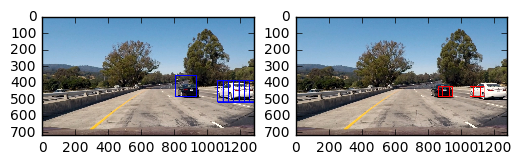

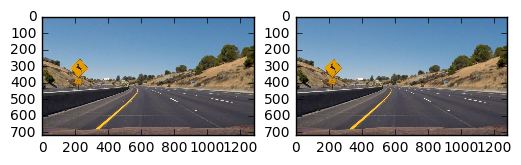

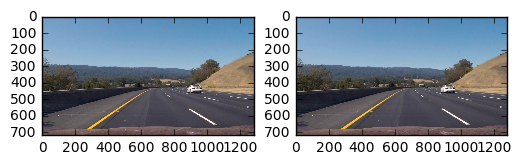

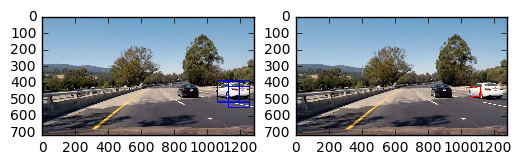

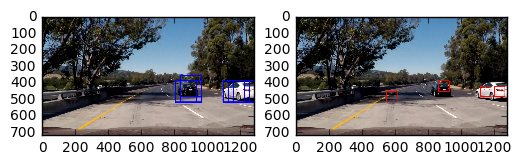

In [47]:
profiler.reset()
for f in test_images[0:5]:#test_images/cars:
    plt.figure()
    im = plt.imread(f)
    plt.subplot(1,2,1)
    profiler.start('find_new')
    imout1 = detector.find_cars(plt.imread(f),scale=2,ystart=im.shape[0]//2)
    profiler.end()
    plt.imshow(imout1)
    plt.subplot(1,2,2)
    profiler.start('find_old')
    imout2 = detector.find_and_draw_detections(im)
    profiler.end()
    plt.imshow(imout2)
profiler.report()
    #print('max',np.max(im),'dtype',im.dtype)
    #plt.imshow(imout)

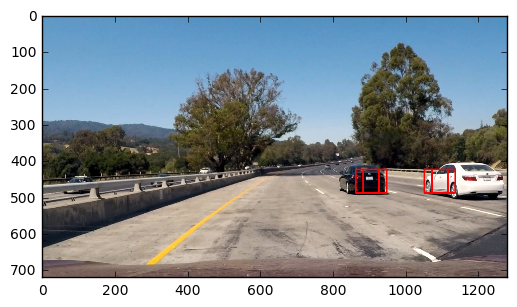

In [48]:
im = detector.find_and_draw_detections(plt.imread(test_images[0]))
plt.imshow(im)

In [31]:
def car_detector_fast_find_and_draw_detections(self, im):
    im2=rgb_to_colorspace(im, self.colorspace)
    hog_features = []
    for channel in range(3):
        f = hog(im[:,:,channel],self.orientations,(self.pixels_per_cell,self.pixels_per_cell),(self.cells_per_block,self.cells_per_block),feature_vector=False)
        hog_features.append(f)
    return
    image_height = im.shape[0]
    image_width = im.shape[1]
    tile_width=64
    tile_height=64
    for x in range(0, image_width-tile_width-1, tile_width//3):
        for y in range(image_height//2, image_height-tile_height-1, tile_height//3):
            v = im2[y:y+tile_height,x:x+tile_width,:]
            is_car = self.detect(v)
            color = (255,0,0) if is_car else (127,127,127)
            thickness = 3 if is_car else 1
            if is_car:
                cv2.rectangle(im,(x,y),(x+tile_width,y+tile_height),color,thickness=thickness)
    return im
                
CarDetector.fast_find_and_draw_detections = car_detector_fast_find_and_draw_detections

In [32]:
%%time
start = 3
count = 2
for f in test_images[start:start+count]:
    t1 = mpimg.imread(f)
    t2 = smaller_size(t1)
    t3 = smaller_size(t2)
    t4 = smaller_size(t3)

    for im in [t1,t2,t3,t4]:
        detector.fast_find_and_draw_detections(im)


CPU times: user 3.5 s, sys: 12 ms, total: 3.51 s
Wall time: 2.54 s


"get_features" duration: 7.35 count: 1996
"predict" duration: 0.42 count: 1995
"transform" duration: 0.08 count: 1996
CPU times: user 8.78 s, sys: 0 ns, total: 8.78 s
Wall time: 7.91 s


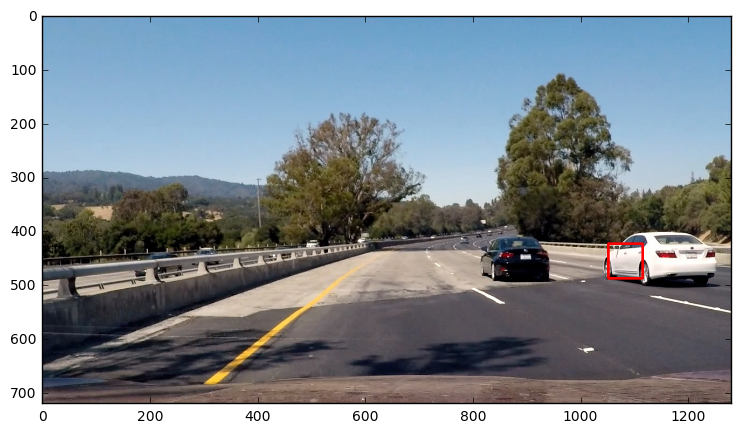

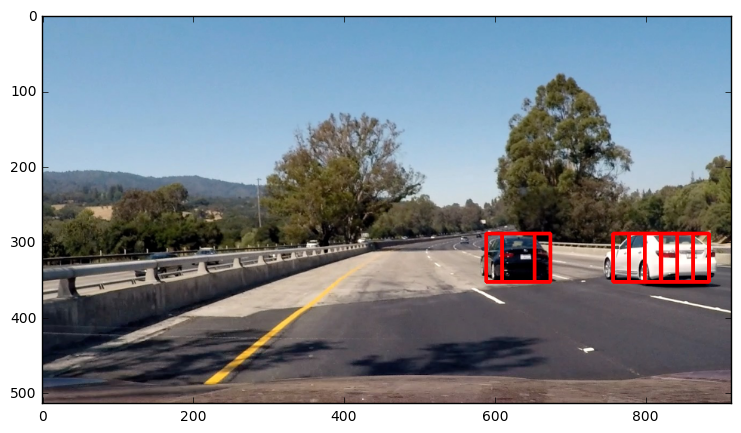

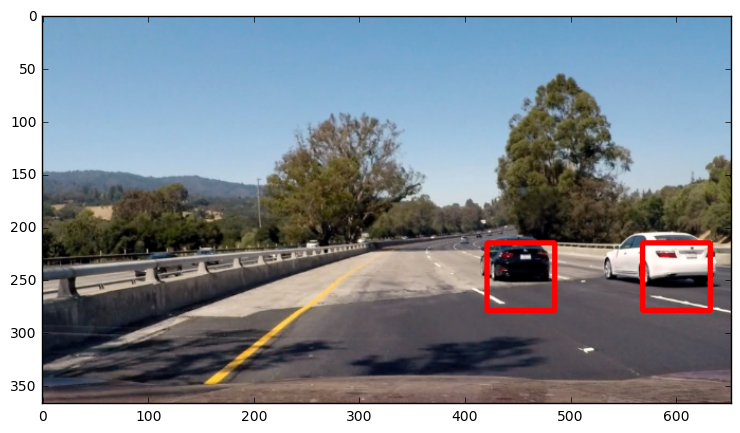

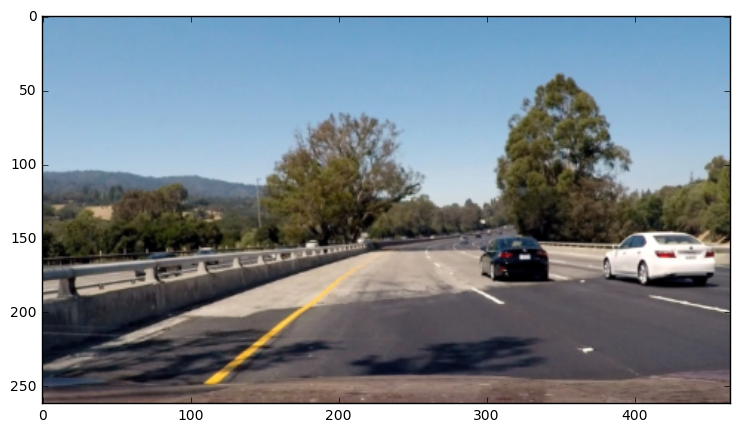

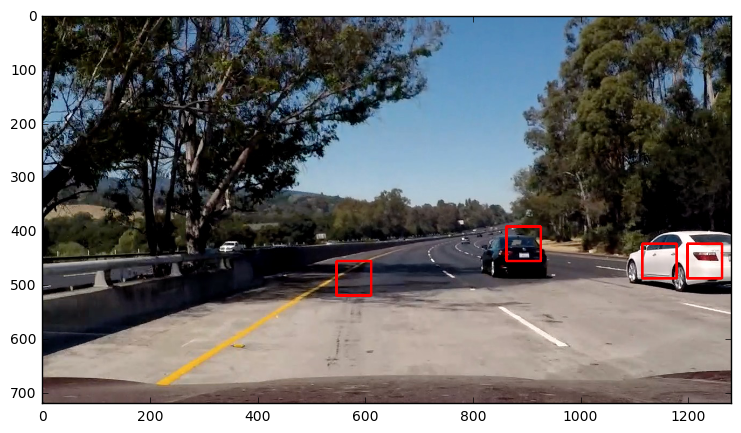

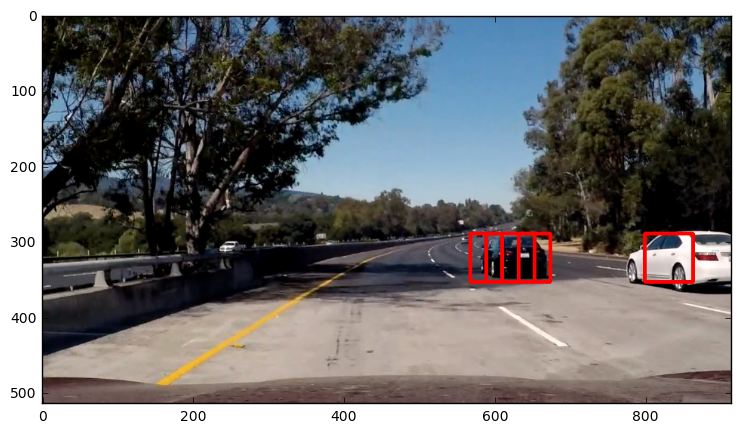

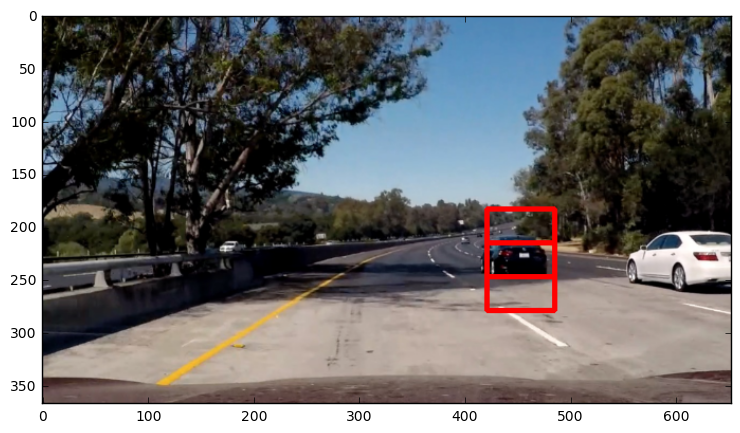

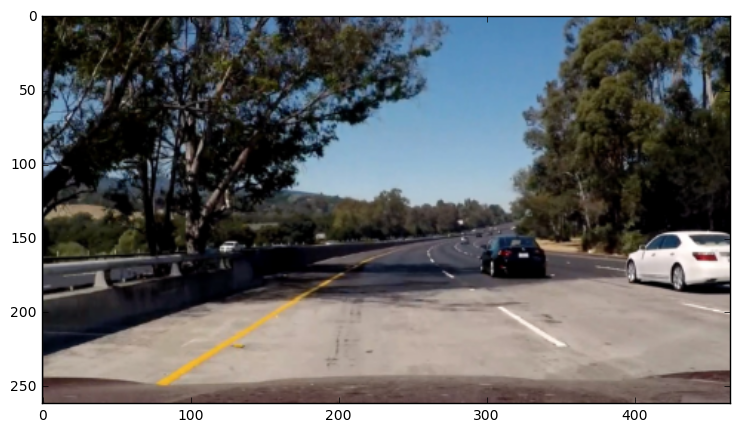

In [33]:
%%time
profiler.reset()
start = 3
count = 2
for f in test_images[start:start+count]:
    t1 = mpimg.imread(f)
    t2 = smaller_size(t1)
    t3 = smaller_size(t2)
    t4 = smaller_size(t3)

    for im in [t1,t2,t3,t4]:
        detector.find_and_draw_detections(im)
        fig=plt.figure()
        fig.set_size_inches(w=10,h=5)
        plt.imshow(im)
profiler.report()

In [34]:
class FastHog:
    def __init__(self, im):
        self.orientations=16
        self.patch_side = 64
        self.cell_side = 8
        self.cells_per_patch = self.patch_side // self.cell_side
        self.pixels_per_cell = (self.cell_side,self.cell_side)
        self.cells_per_block=(1,1)
        self.im = im
        self.v = hog(
            im, 
            orientations = self.orientations,
            transform_sqrt = False,
            cells_per_block=self.cells_per_block,
            pixels_per_cell=self.pixels_per_cell,
            feature_vector=False)
    def hog(self,x,y):
        im_hog = self.im[y:y+self.patch_side,x:x+self.patch_side]
        return hog(
            im_hog,
            orientations = self.orientations,
            transform_sqrt = False,
            cells_per_block=self.cells_per_block,
            pixels_per_cell=self.pixels_per_cell,
            feature_vector=False).ravel()
    def fast_hog(self,x,y):
        x_cell = x//self.cell_side
        y_cell = y//self.cell_side
        return self.v[y_cell:y_cell+self.cells_per_patch,x_cell:x_cell+self.cells_per_patch].ravel()

#im = plt.imread(notcars[0])[:,:,0]
im = plt.imread(test_images[0])[:,:,0].astype(np.float32)/255.
print(im.shape)
print(np.array(im.shape)/8.)

#plt.imshow(im)
h = FastHog(im)
print(h.v.shape)
x=0
for y in range(64,74):
    for x in range(64,74):
        v1 = h.hog(x,y)
        v2 = h.fast_hog(x,y)
        print(x,'v1:',np.round(v1[:3],3), 'v2:',np.round(v2[:3],3),'diff',np.sum(np.abs(v2-v1)))


(720, 1280)
[  90.  160.]
(90, 160, 1, 1, 16)
64 v1: [ 0.059  0.     0.   ] v2: [ 0.05   0.039  0.   ] diff 5.48799480552
65 v1: [ 0.073  0.     0.   ] v2: [ 0.05   0.039  0.   ] diff 13.4724089668
66 v1: [ 0.087  0.     0.   ] v2: [ 0.05   0.039  0.   ] diff 17.6245490632
67 v1: [ 0.155  0.     0.   ] v2: [ 0.05   0.039  0.   ] diff 22.5336846223
68 v1: [ 0.151  0.     0.031] v2: [ 0.05   0.039  0.   ] diff 26.6064446306
69 v1: [ 0.149  0.     0.079] v2: [ 0.05   0.039  0.   ] diff 31.2582279446
70 v1: [ 0.123  0.     0.129] v2: [ 0.05   0.039  0.   ] diff 34.6433029896
71 v1: [ 0.144  0.     0.124] v2: [ 0.05   0.039  0.   ] diff 39.480997378
72 v1: [ 0.181  0.     0.141] v2: [ 0.107  0.     0.125] diff 4.9730087234
73 v1: [ 0.162  0.     0.135] v2: [ 0.107  0.     0.125] diff 13.3830983634
64 v1: [ 0.042  0.     0.   ] v2: [ 0.05   0.039  0.   ] diff 14.3422143425
65 v1: [ 0.056  0.     0.   ] v2: [ 0.05   0.039  0.   ] diff 18.3234239889
66 v1: [ 0.057  0.     0.   ] v2: [ 0.05   0

In [35]:
2916/(9*3*3)

36.0

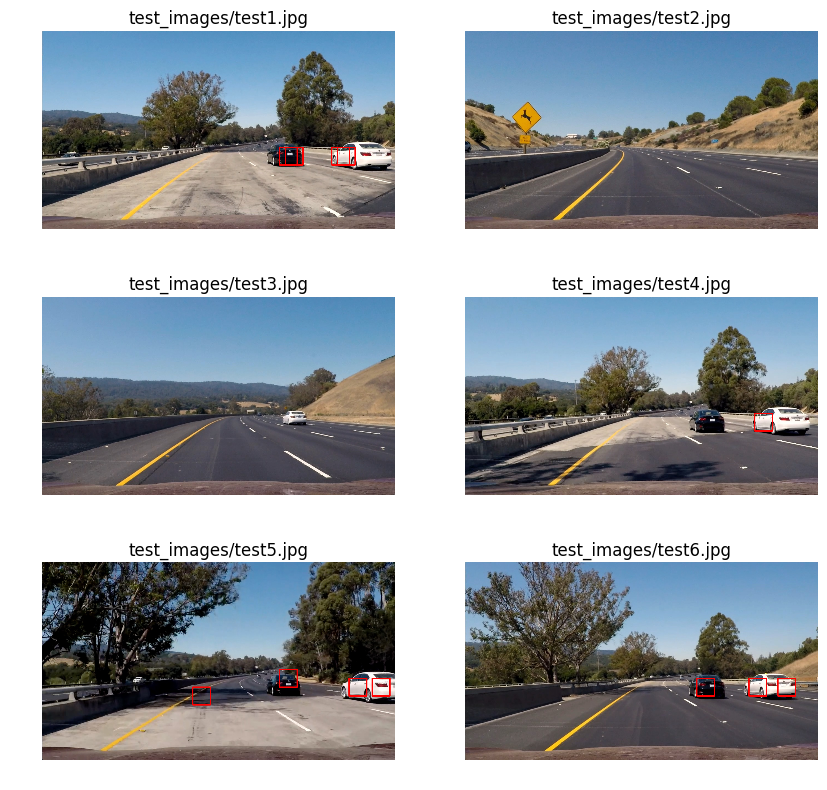

In [36]:
fig = plt.figure()
fig.set_size_inches(w=10,h=20)
for i,f in enumerate(test_images):
    im=mpimg.imread(f)
    detector.find_and_draw_detections(im)
    plt.subplot(len(test_images),2,i+1)
    plt.imshow(im)
    plt.title(f)
    plt.axis('off')

### Parameter Optimizations

In [37]:
raise ValueError("by default, this part of the notebook isn't run, select cells and run manually")

ValueError: by default, this part of the notebook isn't run, select cells and run manually

In [ ]:
#import plotly.plotly as py
import plotly
import plotly.offline
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

import numpy as np
def show_vehicles_color_plot(colorspace='LUV'):
    data = []
    opacity = .3
    size=2

    cvt = lambda im: rgb_to_colorspace(im,colorspace)
    x=[]
    y=[]
    z=[]
    for f in glob.glob('color_spaces/vehicles/*'):
        im = cvt(plt.imread(f))
        x=np.append(x,im[:,:,0].ravel())
        y=np.append(y,im[:,:,1].ravel())
        z=np.append(z, im[:,:,2].ravel())


    data.append(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        #legendgroup='vehicles',
        mode='markers',
        marker=dict(
            size=size,
            #color='rgba(255, 0, 0,1)',
            opacity=opacity
        ),
        name = 'vehicles'
    ))

    x=[]
    y=[]
    z=[]

    for f in glob.glob('color_spaces/non-vehicles/*'):
        im = cvt(plt.imread(f))
        x=np.append(x,im[:,:,0].ravel())
        y=np.append(y,im[:,:,1].ravel())
        z=np.append(z, im[:,:,2].ravel())

    data.append(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=size,
            #color='rgba(0, 0, 0, 1)',
            opacity=opacity
        ),
        name = 'non-vehicles'
    ))


    #data = [trace1, trace2]
    layout = go.Layout(
        title='colorspace '+colorspace,
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        ),
        showlegend='True'
    )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig)#, filename='simple-3d-scatter')

In [ ]:
for colorspace in colorspaces:
    show_vehicles_color_plot(colorspace)

In [ ]:
detector = CarDetector()
best_accuracy = 0.0
for spatial in [4,6,8,12,16,20,24,28,32,64]:
    detector.train(ignore_hog = True, spatial_size=spatial,sample_size=1000)
    print('spatial: ',spatial, 'accuracy: ', detector.accuracy, 'feature_count: ', detector.feature_count)
    if detector.accuracy > best_accuracy:
        best_accuracy = detector.accuracy
        best_spatial = spatial
print('the best spatial was:', best_spatial)
print(detector.describe())

In [ ]:
spatial = best_spatial
best_accuracy = 0
for colorspace in colorspaces:
    detector.train(colorspace=colorspace, spatial_size=spatial,ignore_hog=True)
    print('colorspace: ',colorspace, 'accuracy: ', detector.accuracy, 'feature_count: ', detector.feature_count)
    if detector.accuracy > best_accuracy:
        best_accuracy = detector.accuracy
        best_colorspace = colorspace
print('the best colorspace was:', best_colorspace)
print(detector.describe())

In [ ]:
spatial = best_spatial
colorspace = best_colorspace
best_accuracy = 0
for histbin in [8,12,16,20,24,28,32,48,64,128,256]:
    detector.train(
        sample_size=1000,
        ignore_hog = True, 
        colorspace=colorspace, 
        spatial_size=spatial,
        hist_bins=histbin)
    print('histbin: ',histbin, colorspace, 'accuracy: ', detector.accuracy, 'feature_count: ', detector.feature_count, 'histbin',histbin)
    if detector.accuracy > best_accuracy:
        best_accuracy = detector.accuracy
        best_histbin = histbin
print('the best histbin was:', best_histbin)

In [ ]:
histbin = best_histbin
best_accuracy = 0
for orientations in [3,4,5,6,7,8,9,10,11,12,14,16,18,22,24,28]:
    detector.train(
        orientations=orientations, hist_bins=best_histbin)
    print('orientations: ',orientations, 'accuracy: ',detector.accuracy, 'feature_count: ', detector.feature_count)
    if detector.accuracy > best_accuracy:
        best_accuracy = detector.accuracy
        best_orientations = orientations
print('the best orientations was:',best_orientations)

In [ ]:
print(detector.describe())

In [ ]:
spatial = 4
colorspace = 'LUV' 
histbin = 16    # 256 was had a higher test accuracy, but I'm afraid that may over-fit

In [ ]:
detector.train(
    sample_size=99999,
    ignore_hog = False, 
    colorspace=colorspace, 
    spatial_size=spatial,
    hist_bins=histbin)

In [ ]:
print('spatial: ',detector.spatial_size, 'colorspace: ', detector.colorspace, 'accuracy: ', detector.accuracy, 'feature_count: ', detector.feature_count, 'histbin',detector.hist_bins)


In [ ]:
best_accuracy = 0
for hog_channel in [0,1,2,'ALL']:
    detector.train(
        sample_size=1000,
        ignore_hog = False,
        colorspace=colorspace, 
        hog_channel=hog_channel,
        hist_bins=histbin)
    print('hog_channel: ',hog_channel,  'accuracy: ', detector.accuracy, 'feature_count: ', detector.feature_count)
    if detector.accuracy > best_accuracy:
        best_accuracy = detector.accuracy
        best_colorspace = colorspace
        best_hog_channel = hog_channel
print('the best hog_channel was:', best_hog_channel)
print(detector.describe())

    

    orientations:  3 colorspace:  HLS hog_channel:  0 accuracy:  0.885 feature_count:  2700
    orientations:  4 colorspace:  HLS hog_channel:  0 accuracy:  0.915 feature_count:  3600
    orientations:  5 colorspace:  HLS hog_channel:  0 accuracy:  0.925 feature_count:  4500
    orientations:  6 colorspace:  HLS hog_channel:  0 accuracy:  0.94 feature_count:  5400
    orientations:  7 colorspace:  HLS hog_channel:  0 accuracy:  0.965 feature_count:  6300
    orientations:  8 colorspace:  HLS hog_channel:  0 accuracy:  0.955 feature_count:  7200
    orientations:  9 colorspace:  HLS hog_channel:  0 accuracy:  0.93 feature_count:  8100
    orientations:  10 colorspace:  HLS hog_channel:  0 accuracy:  0.94 feature_count:  9000
    orientations:  11 colorspace:  HLS hog_channel:  0 accuracy:  0.955 feature_count:  9900
    orientations:  12 colorspace:  HLS hog_channel:  0 accuracy:  0.98 feature_count:  10800
    the best colorspace was: HSV
    the best hog_channel was: ALL

In [ ]:
for hog_channel in [0,'ALL']:
    colorspace = 'HLS'
    orientations = 12
    for pixels_per_cell in [3,4,5,6,7,8,9,10,11,12]:
        accuracy, feature_count,svc,_ = train_hog_classifier(sample_size=1000,colorspace=colorspace,hog_channel=hog_channel,orientations=orientations,pixels_per_cell=pixels_per_cell)
        print('pixels_per_cell',pixels_per_cell, 'orientations: ',orientations, 'colorspace: ', colorspace, 'hog_channel: ',hog_channel,  'accuracy: ', accuracy, 'feature_count: ', feature_count)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_pixels_per_cell = pixels_per_cell
            best_hog_channel = hog_channel
    print('the best_pixels_per_cell was:', best_pixels_per_cell)
    print('the best hog_channel was:', best_hog_channel)

In [ ]:
pixels_per_cell = 8
colorspace = 'HSV'
orientations=12
hog_channel = 'ALL'
accuracy, feature_count,svc,scalar = train_hog_classifier(sample_size=10000,colorspace=colorspace,hog_channel=hog_channel,orientations=orientations,pixels_per_cell=pixels_per_cell)
print('pixels_per_cell',pixels_per_cell, 'orientations:',orientations, 'colorspace:', colorspace, 'hog_channel:',hog_channel,  'accuracy: ', accuracy, 'feature_count: ', feature_count)
